### This code (in progress) will calculate the shallow ice approximation (SIA) velocities for a specific ice rise

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


In [10]:
# Read in bed, grounding line, ice surface and velocity data

data_bed = pd.read_csv('../data/HIR_BedElevation_Bedmachine.csv', delimiter=' ')
data_GL = pd.read_csv('../data/HIR_GL.csv', delim_whitespace=True)
data_surf = pd.read_csv('../data/HIR_SurfaceElevation_REMA.csv', delimiter=' ')
data_vel = pd.read_csv('../data/HIR_SurfaceVelocity.csv', delim_whitespace=True)


In [11]:
# Reduce the number of data points for the surface for computational efficiency. 
# The plan is to run the code on the cluster using all data points

data_surf = data_surf.iloc[::1000, :]
data_surf = data_surf.reset_index()

In [12]:
# Reduce the grounding line file to only include relevant data points

data_GL_reduced = data_GL.loc[56:141]

# Add an extra data point in the domain corner and create polygon

new_row = pd.DataFrame({'X':data_GL['X'][56], 'Y':data_GL['Y'][141]}, index=[0])
data_GL_reduced_extra_point = pd.concat([new_row,data_GL_reduced.loc[:]]).reset_index(drop=True)
poly = Polygon(zip(list(data_GL_reduced_extra_point['X']), list(data_GL_reduced_extra_point['Y'])))

# Remove data points which lie outwith the grounding line. This is computationally expensive. 
# Is there a way to reduce compute time?

for i in range(len(data_surf)):
    boolean = poly.contains(Point(data_surf['X'][i], data_surf['Y'][i]))
    if boolean == False:
        data_surf = data_surf.drop(i)


In [13]:
# Choose domain coordinates, create regular grid and interpolate unstructured data onto regular grid

xmin, xmax = 770000, 825000
ymin, ymax = 1960000, 2020000
nx, ny = int((xmax - xmin)/1000 + 1), int((ymax - ymin)/1000 + 1)

x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
grid_x, grid_y = np.meshgrid(x, y)
surf = scipy.interpolate.griddata((data_surf["X"], data_surf["Y"]), data_surf["surf"], (grid_x, grid_y), method='linear')


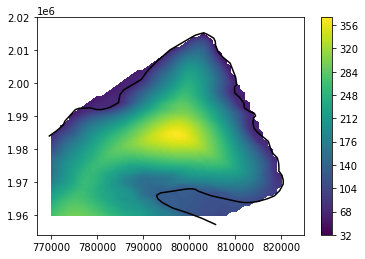

In [14]:
fig, ax = plt.subplots(1, 1)
CS = ax.contourf(grid_x, grid_y, surf, 100)
ax.plot(data_GL_reduced['X'], data_GL_reduced['Y'], color='black')
cbar = fig.colorbar(CS)

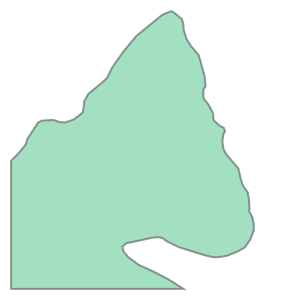

In [15]:
poly

### Next steps:
- Grid bed data
- Subtract bed from surface data to calculate ice thickness
- Concatenate datasets: use ndarray, xarray?
- Calculate surface slope while data is gridded
- Calculate SIA assuming only deformational velocity component
- Validate velocities with observed velocities
- Create scripts for cluster for computationally expensive code